In [27]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os
import numpy as np
import matplotlib.pyplot as plt

In [5]:
images_dir = "training/"
labels = pd.read_csv("training_labels.csv")

# add the directory to the filename
labels['ID'] = labels['ID'].apply(lambda x: os.path.join(images_dir, x))

# Initialize the ImageDataGenerator
# You can change the size of the validation split (0.25 is 25% of data used as validation set)
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.25,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create the training and validation generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory=None,  
    x_col='ID',
    y_col='target',
    target_size=(224, 224), # You can change the size of the image
    batch_size=32, # You can change the batch_size
    class_mode='categorical',  
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=labels,
    directory=None,  
    x_col='ID',
    y_col='target',
    target_size=(224, 224), # Should match training size
    batch_size=32, # Should match training
    class_mode='categorical',  
    subset='validation'
)

Found 2591 validated image filenames belonging to 5 classes.
Found 863 validated image filenames belonging to 5 classes.


### ONLY RUN THIS TO SEE THE PICTURES. SKIP IT OTHERWISE

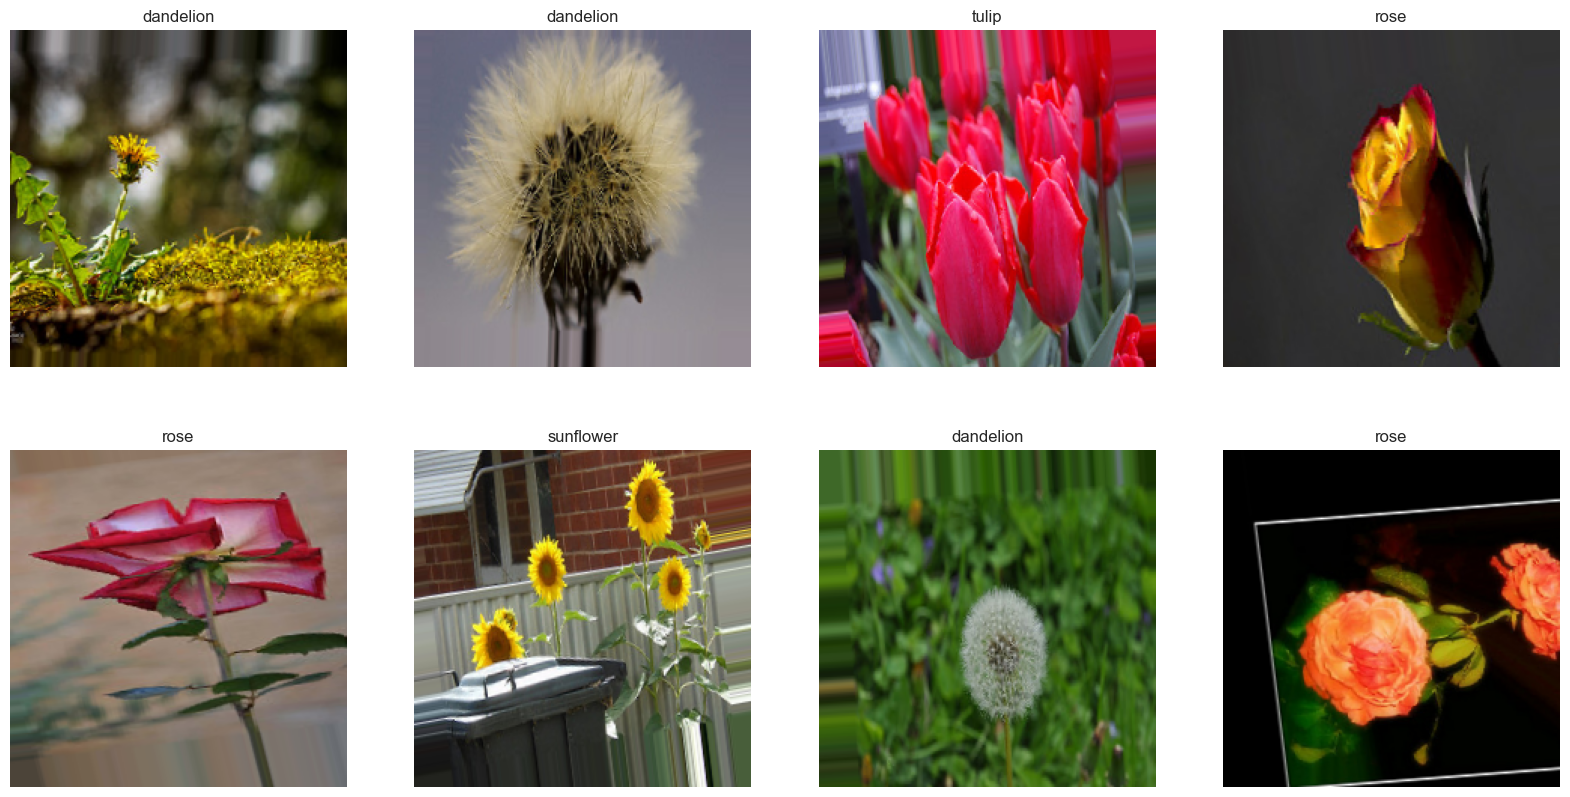

In [3]:
## Plot a few of the images
# 
# # Fetch a batch of images and their labels
# images, labels = next(train_generator)
# 
# # Number of images to show
# num_images = 8
# 
# plt.figure(figsize=(20, 10))
# for i in range(num_images):
#     ax = plt.subplot(2, 4, i + 1)
#     plt.imshow(images[i])
#     # The label for current image
#     label_index = labels[i].argmax()  # Convert one-hot encoding to index
#     label = list(train_generator.class_indices.keys())[label_index]  # Get label name from index
#     plt.title(label)
#     plt.axis('off')
# plt.show()


### Training Code

In [6]:
base_mod = ResNet50(weights='imagenet')

# Freeze the base model layers
for layer in base_mod.layers[-10:]:
    layer.trainable = True

# Create the model
model = Sequential([
    base_mod,
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer = l2(0.01)),
    Dropout(0.5),
    Dense(len(labels['target'].unique()), activation='softmax')  # Number of classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(
    train_generator,
    validation_data= validation_generator, 
    epochs = 10
)

C:\Users\jessa\anaconda3\envs\stat486\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 594s 7s/step - accuracy: 0.3164 - loss: 2.7496 - val_accuracy: 0.2422 - val_loss: 1.6248
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 507s 6s/step - accuracy: 0.2283 - loss: 1.6053 - val_accuracy: 0.2422 - val_loss: 1.6153
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 456s 6s/step - accuracy: 0.2981 - loss: 1.5806 - val_accuracy: 0.2422 - val_loss: 1.6089
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 455s 6s/step - accuracy: 0.3640 - loss: 1.4931 - val_accuracy: 0.2422 - val_loss: 1.6568
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 451s 6s/step - accuracy: 0.3658 - loss: 1.4475 - val_accuracy: 0.2422 - val_loss: 1.6819
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 462s 6s/step - accuracy: 0.3723 - loss: 1.4003 - val_accuracy: 0.2422 - val_loss: 1.7057
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 456s 6s/step - accuracy: 0.3838 - loss: 1.4077 - val_accuracy: 0.2422 - val_loss: 1.7155
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 475s 6s/step - accuracy: 0.3777 - loss: 1.4260 - val_accuracy: 0.2422 - v

### Test Data!

In [28]:
def load_and_preprocess_images(directory, target_size):
    images = []
    filenames = []
    
    for filename in os.listdir(directory):
        if filename.endswith(('.png', '.jpg', '.jpeg')):  # Adjust file types as necessary
            img_path = os.path.join(directory, filename)
            img = load_img(img_path, target_size=target_size)  # Load image with target size
            img_array = img_to_array(img) / 255.0  # Convert to array and scale
            images.append(img_array)
            filenames.append(filename)  # Save the filename (ID)
    
    return np.array(images), filenames

# Directory containing the test images
testing_directory = "testing" 
target_size = (224, 224)  # Adjust based on your model's input size

# Load and preprocess images
test_images, image_ids = load_and_preprocess_images(testing_directory, target_size)

# Make predictions
predictions = model.predict(test_images)  # Get predictions
predicted_indices = np.argmax(predictions, axis=1)  # Get the class indices

class_labels = {v: k for k, v in train_generator.class_indices.items()}  # Adjust this as necessary

# Convert indices to class labels
predicted_labels = [class_labels[idx] for idx in predicted_indices]

# Prepare the DataFrame
output = pd.DataFrame({
    'ID': image_ids,  # Filenames as IDs
    'Prediction': predicted_labels  # Predicted labels
})

# Save to CSV
output.to_csv("predictions.csv", index=False)

27/27 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step
